# Sentiment Analysis on Movie Reviews - Baseline Model

## Introduction
This notebook serves as a baseline model for the **Sentiment Analysis on Movie Reviews** competition. The goal is to classify movie reviews as different sentiment classes.

In this notebook, we will:
1. **Load and explore the dataset**
2. **Preprocess the text (cleaning, tokenization, TF-IDF)**
3. **Train a baseline model (Linear Regression, Logistic Regression, and NN)**
4. **Evaluate its performance**


### Import Libraries

In [1]:
from collections import Counter
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import string

### Step 1: Data Ingestion

In this step, we load the `train.tsv` file into a Pandas DataFrame and perform basic checks. This includes verifying the overall structure of the dataset (rows and columns) and previewing a few entries with `df.head()`. These actions ensure the data is properly loaded before we proceed with further exploration and analysis.

In [2]:
df = pd.read_csv("train.tsv", sep="\t")
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


---
### Step 2: Data Cleaning

In this step, we ensure the dataset is properly prepared before moving on to deeper analysis and modeling. We also wrap the cleaning steps in a function to be used for later loading test data and do the same cleaning.
1. **Checking for missing values** and removing or correcting any invalid rows (for example, those with empty `Phrase` fields). 
2. **Remove the `SentenceId` column**, because it functions purely as an identifier for grouping phrases by sentence and does not provide direct value for our initial baseline model.
3. **Remove rows** where phrase is empty.
4. **Check for duplicates** and address any outliers, ensuring our data is clean and consistent for the subsequent steps.
5. **Lower Case** to standardizes the text, so that words like "Movie" and "movie" are treated as the same token. 
6. **Remove Punctuation**: Punctuation is typically not useful for sentiment classification and can add noise, so removing it simplifies the text.
7. **Lemmatization**: Normalize different variations of the same word (e.g., “running” → “run”). 

In [3]:
def clean_data(df):
    # 1. Check for missing values
    print("Missing values in each column:")
    print(df.isnull().sum())

    # 2. Remove the SentenceId column
    #    This column is not needed for our baseline model.
    df = df[['PhraseId', 'Phrase','Sentiment']]
    df.shape

    # 3. Reemove rows where phrase is empty.
    initial_count = df.shape[0]
    df = df[df['Phrase'].str.strip() != '']
    removed_empty_count = initial_count - df.shape[0]
    print(f"\nRemoved {removed_empty_count} rows where Phrase was empty.")

    # 4. Check for duplicates
    duplicates_count = df.duplicated().sum()
    df.drop_duplicates(inplace=True)
    print(f"\nNumber of duplicate rows: {duplicates_count}")

    # 5. Lowercasing
    df["Phrase"] = df["Phrase"].str.lower()

    # 6. Remove Punctuation
    df["Phrase"] = df["Phrase"].str.translate(str.maketrans("", "", string.punctuation))

    # 7. Lemmatization
    nltk.download('wordnet', quiet=True)
    lemmatizer = WordNetLemmatizer()
    df["Phrase"] = df["Phrase"].apply(lambda text: " ".join([lemmatizer.lemmatize(word, pos="v") for word in text.split()]))
    
clean_data(df=df)

Missing values in each column:
PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

Removed 1 rows where Phrase was empty.

Number of duplicate rows: 0


---
### Step 3: Exploratory data analysis

#### Sentiment Distribution

**Purpose**  
Understanding sentiment distribution is important because it reveals class imbalances that could bias the model's learning process. A heavily skewed distribution might mean the model will have difficulty learning the minority classes. By examining the count and percentage of reviews in each sentiment category, we can determine if the dataset is balanced or if we need to apply techniques to address any imbalance.

**Conclusion**  
From the chart, it appears that **neutral (sentiment 2)** dominates the dataset, while **extremely positive (4)** and **extremely negative (0)** are less frequent. Because of this imbalance, we may need to take extra steps to prevent the model from focusing too heavily on the most common sentiment.



Sentiment Distribution (% of total reviews):
 Sentiment  count proportion
         0   7072      4.53%
         1  27273     17.48%
         2  79582     50.99%
         3  32927     21.10%
         4   9206      5.90%


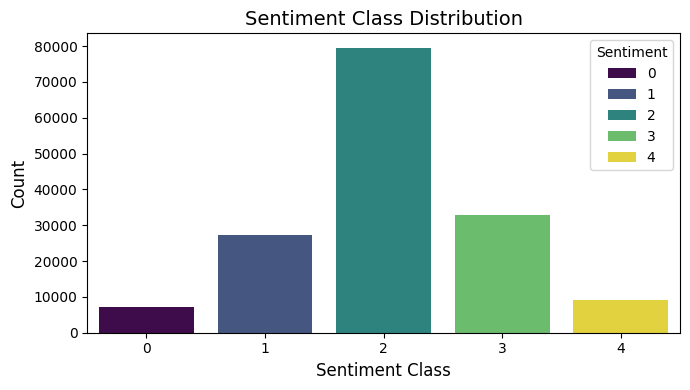

In [4]:
# Calculate the count and percentage of each sentiment class
sentiment_percent = df["Sentiment"].value_counts().reset_index().sort_values(by='Sentiment')
sentiment_percent.columns = ['Sentiment', 'count']
sentiment_percent['proportion'] = sentiment_percent['count'] / df.shape[0] * 100
sentiment_percent['proportion'] = sentiment_percent['proportion'].apply(lambda x: f"{x:.2f}%")

print("Sentiment Distribution (% of total reviews):")
print(sentiment_percent.to_string(index=False))

# Visualize the sentiment distribution
plt.figure(figsize=(7, 4))
sns.countplot(data=df, x="Sentiment", hue="Sentiment", palette="viridis")
plt.title('Sentiment Class Distribution', fontsize=14)
plt.xlabel('Sentiment Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

---
### Step 3: Exploratory Data Analysis - cont'd

#### Phrase Length Analysis

**Purpose**  
Examining the length of each phrase (in words) helps us determine whether certain sentiments are associated with shorter or longer text. It also reveals potential outliers (very short or very long phrases) that may skew the model’s performance.

**Conclusion**  
From the boxplot, we see that **neutral** (sentiment 2) phrases tend to be shorter, while other sentiments have higher median lengths and more outliers. This pattern suggests that expressing a stronger sentiment—whether positive or negative—often involves using more words.


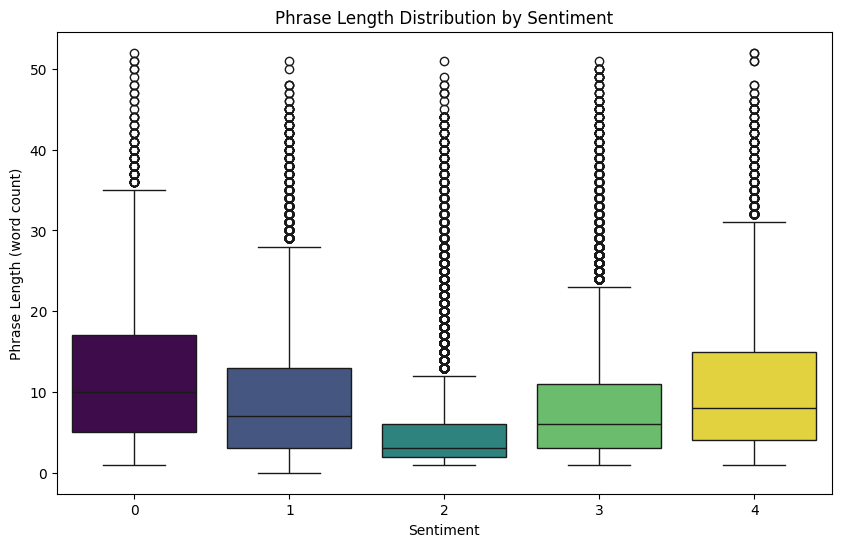

In [5]:
df["Phrase_length"] = df["Phrase"].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.boxplot(x='Sentiment', y='Phrase_length', data=df, hue='Sentiment', palette="viridis")
plt.title("Phrase Length Distribution by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Phrase Length (word count)")
plt.legend('', frameon=False)
plt.show()

---
### Step 3: Exploratory Data Analysis - cont'd

#### Most Common Words by Sentiment

**Purpose**  
By identifying the top words for each sentiment category, we can see how language differs across very negative (0), negative (1), neutral (2), positive (3), and very positive (4) phrases. This insight helps us understand which words are common filler terms versus which words might be truly indicative of a certain sentiment.

**Conclusion**  
We observe that some words (e.g., "the", "and") appear frequently in all sentiments, suggesting they are general filler words. Meanwhile, other words—though not immediately obvious from this particular top-10 list—may be more sentiment-specific and could help differentiate negative from positive phrases. These findings can guide us in refining our stopwords list or engineering sentiment-focused features for more accurate classification.


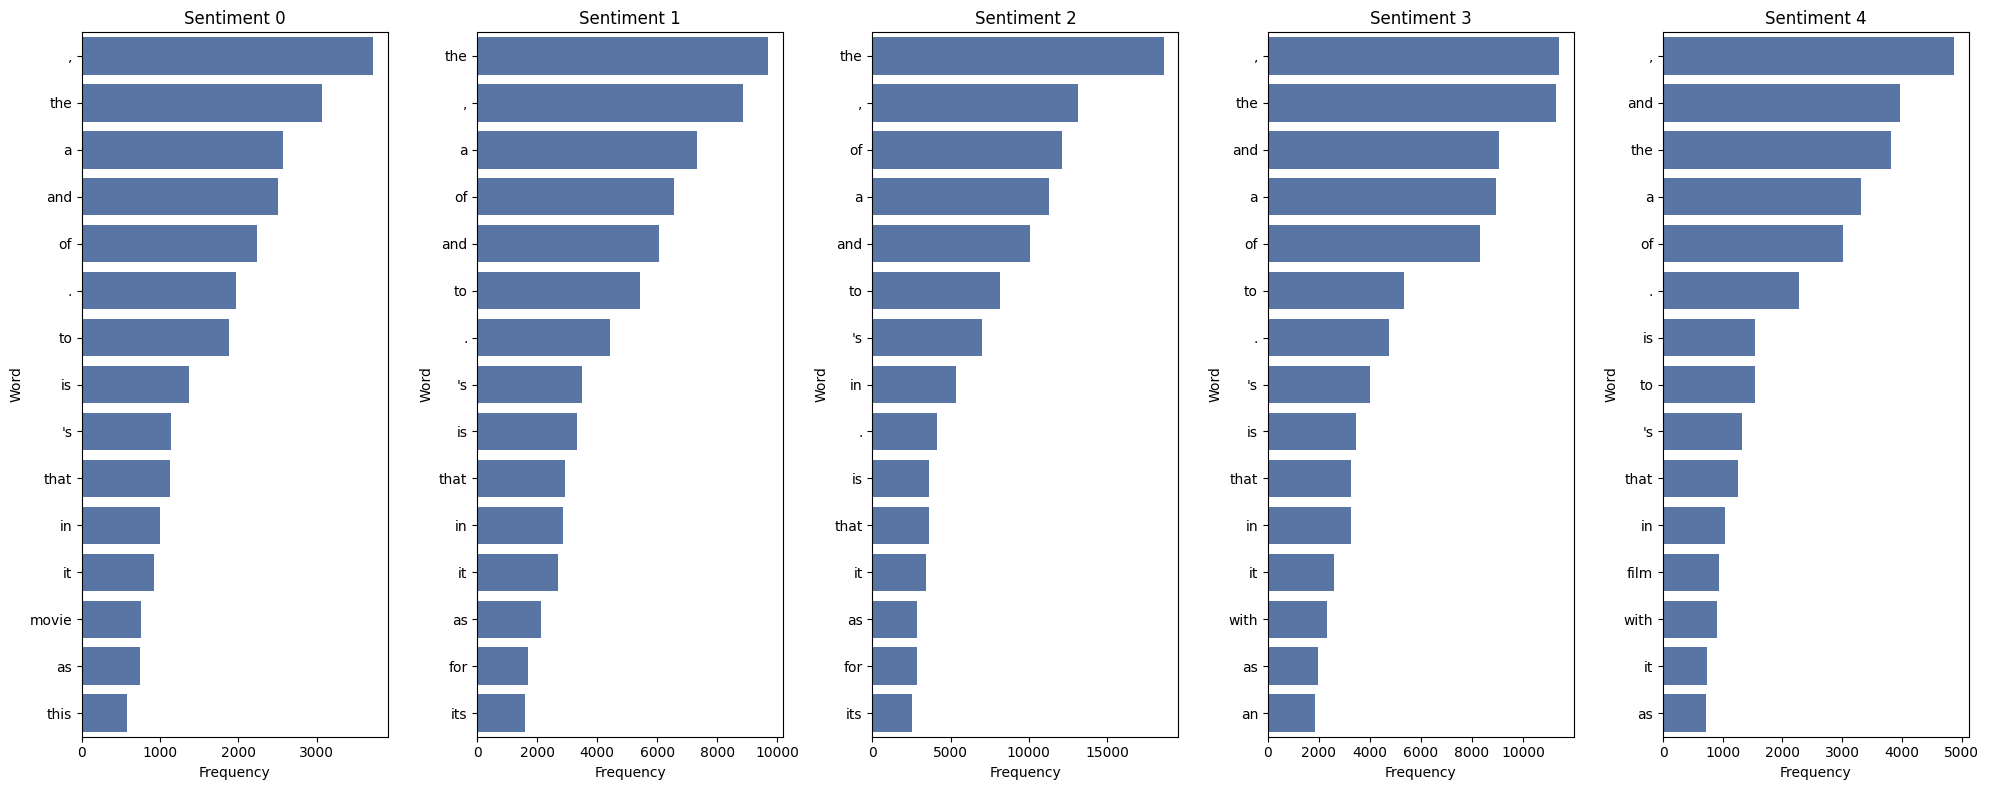

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(20, 8))
sentiments = sorted(df['Sentiment'].unique())
for i, sentiment in enumerate(sentiments):
    subset = df[df['Sentiment'] == sentiment]
    word_counts = Counter(" ".join(subset["Phrase"]).split())
    common_words = word_counts.most_common(15)
    sns.barplot(ax=axes[i],
                x=[count for _, count in common_words],
                y=[word for word, _ in common_words],
                orient='h', color='#4c72b0')
    axes[i].set_title(f"Sentiment {sentiment}")
    axes[i].set_xlabel("Frequency")
    axes[i].set_ylabel("Word")

plt.tight_layout()
plt.show()


---
### Step 4: Data Preprocessing

In this step, we standardize and transform the text data to prepare it for modeling.
   
1. **Stopword Removal:**  
   We define a set of English stopwords (using NLTK) to filter out common words (like "the", "and", etc.) that generally don't contribute to sentiment detection.  
   *Note:* We allow update to this stopwords set.

2. **TF-IDF Vectorization:**  
   We convert the cleaned text into numerical features using TF-IDF, which captures both the term frequency and the relative importance of words across all documents.  
   The TF-IDF vectorizer is fitted on the training set and then used to transform the test set, ensuring that the feature representation is consistent and avoids data leakage.


In [7]:
# Define the default English stopwords using NLTK
stop_words = list(stopwords.words("english"))
# To add custom stopwords, simply update the set. For example:
# 1.
# additional_stopwords = {"example", "anotherword"}
# stop_words.update(additional_stopwords)
# 2.
# important_words = {
#     "not", "no", "never", "none", "nor", "nothing", "nowhere",
#     "hardly", "barely", "scarcely", "very", "too", "so", "just",
#     "quite", "rather", "almost", "much",
#     "aren't", "couldn't", "didn't", "doesn't", "hadn't", "hasn't",
#     "haven't", "isn't", "mightn't", "mustn't", "needn't", "shan't",
#     "shouldn't", "wasn't", "weren't", "won't", "wouldn't"
# }
# stop_words = stop_words - important_words

# Initialize the TF-IDF Vectorizer with the custom stopwords set and limit features to 5000
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)

X = vectorizer.fit_transform(df["Phrase"])
y = df["Sentiment"]
print(f"TF-IDF feature matrix shape: {X.shape}")

feature_names = vectorizer.get_feature_names_out()
first_text_vector = X[0].toarray().flatten()
# see TF-IDF words
top_n = 10
top_indices = np.argsort(first_text_vector)[::-1][:top_n]
top_words = [feature_names[i] for i in top_indices]
top_scores = [first_text_vector[i] for i in top_indices]
print("Top TF-IDF words in first text:")
for word, score in zip(top_words, top_scores):
    print(f"{word}: {score:.4f}")

TF-IDF feature matrix shape: (156060, 5000)
Top TF-IDF words in first text:
good: 0.5203
goose: 0.4535
amounts: 0.4373
occasionally: 0.3825
series: 0.3492
story: 0.2534
fine: 0.0000
films: 0.0000
final: 0.0000
finale: 0.0000


---

### Step 4: Data Preprocessing - cont'd

#### Train, Validation, Test Split
1. **Split into Train and Validation Sets**: Divide the training data (from `train.tsv`) into 60% for training, 20% for validation, 20% for tests.


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1234)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1234)

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Train set: (93636, 5000), Validation set: (31212, 5000), Test set: (31212, 5000)


---
### Step 5: BaseLine Models

---
### Step 6: Evaluation